In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf

In [2]:
# 1. Load Google stock data from Yahoo Finance (single dataset for both training and testing)
data = yf.download('GOOG', start='2010-01-01', end='2024-12-31')
data = data[['Open']]  # Use 'Open' prices, you can also use 'Close' if needed

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
# 2. Preprocess Data
sc = MinMaxScaler(feature_range=(0, 1))
scaled_data = sc.fit_transform(data.values)

In [4]:
# 3. Split the data into training and testing (80/20 split)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [5]:
# 4. Prepare Training Data (Create sequences for LSTM)
X_train = []
y_train = []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])  # Using the previous 60 days' data for prediction
    y_train.append(train_data[i, 0])  # The next day's price is the target

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train to fit the LSTM input format (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [6]:
# 5. Prepare Testing Data (Create sequences for LSTM)
inputs = scaled_data[len(scaled_data) - len(test_data) - 60:]  # Using last 60 days of train data + 60 test days
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [7]:
# 6. Build the LSTM model
regressor = Sequential()

# Adding LSTM layers
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(rate=0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(rate=0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(rate=0.2))

regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout(rate=0.2))

# Output layer
regressor.add(Dense(units=1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# 7. Compile the model
regressor.compile(optimizer='adam', loss='mean_squared_error')

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 2.5904e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 3.2849e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 3.3089e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 2.8537e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - loss: 3.3486e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - loss: 2.9048e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - loss: 3.2717e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - loss: 2.9625e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - loss: 2.7569e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 2.5972e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 2.8573e-04
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 2.6403e-04
Epoch 13/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - loss: 2.8618e-04
Epoch 14/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - loss:

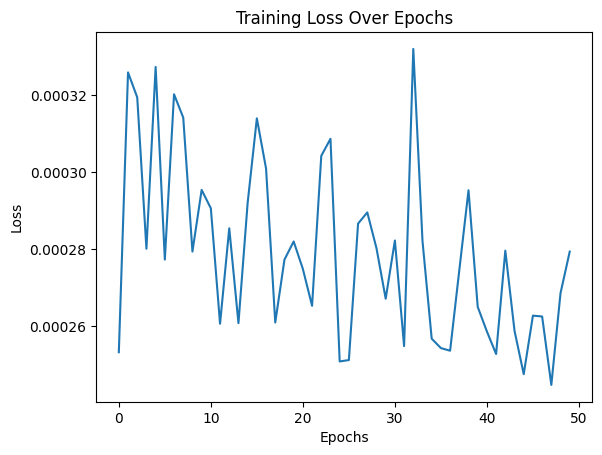

In [15]:
# 8. Train the model
history = regressor.fit(X_train, y_train, batch_size=32, epochs=50)
plt.plot(history.history['loss'])
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [16]:
# 9. Predict the stock prices for test data
predicted_stock_price = regressor.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [17]:
# 10. Inverse transform the predicted stock prices back to original scale
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [18]:
# 11. Prepare the real stock prices for plotting (test data)
real_stock_price = data.iloc[len(data) - len(test_data):, 0].values

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step


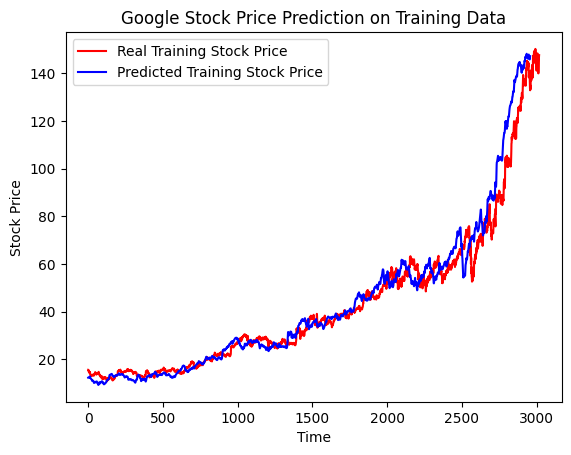

In [19]:
train_pred = regressor.predict(X_train)
train_pred = sc.inverse_transform(train_pred)

plt.plot(data.iloc[:train_size, 0].values, color='red', label='Real Training Stock Price')
plt.plot(train_pred, color='blue', label='Predicted Training Stock Price')
plt.title('Google Stock Price Prediction on Training Data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [21]:
X_train.shape
X_test.shape

(755, 60, 1)